# Synopsis

We run PCA and HCA on the Federelist Papers using SKLearn to do our preprocessing and vectorization. We bypass Pandas and friends for sake of speed, since we are not interested in creating an "edition" of the texts here. If we wanted to experiment with the effects of NLP preprocessing decisions and also wanted to interact with the contents of the files, we would consider using our standard approach to corpus ingestion and modeling.

Note the difference between turning stop words on and off. 

# Configuration

In [105]:
source_dir = 'vierthaler-stylometry/fedpapers'
use_idf = True
# stop_words = None
stop_words = 'english'
max_features = 1000
n_components = 10

# Libraries

In [106]:
import glob
import re

# For PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# For HCA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

# For Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.colors

# Pragmas

In [107]:
%matplotlib inline

# Process

## Import the files into lists

In [108]:
files = glob.glob(source_dir+'/*.txt')
codes = [f.replace('.txt','').split('/')[-1].split('_') for f in files]
texts = [open(f, 'r', encoding='utf-8').read() for f in files]

In [109]:
titles = [re.sub(r'\n+', ' ', text.strip())[:80] for text in texts]
titles = [re.sub(r'The Same Subject Continued \(', '', title)[:40] for title in titles]

## Use SKL to create TFIDF matrix

In [110]:
countVectorizer = TfidfVectorizer(max_features=max_features, use_idf=use_idf, stop_words=stop_words)
countMatrix1 = countVectorizer.fit_transform(texts)

## Normalize matrix 

In [111]:
countMatrix = normalize(countMatrix1)
countMatrix = countMatrix.toarray()

## PCA

### Generate PCA

In [112]:
pca = PCA(n_components=n_components)
projected = pca.fit_transform(countMatrix)

### Plot PCA

In [113]:
authors = [code[1] for code in codes]
letters = list(set(authors))
author_ids = [letters.index(x) for x in authors]

In [114]:
def plot_pca(proj, pc_a=0, pc_b=1):
    plt.figure(figsize=(15,10))
    plt.scatter(proj[:, pc_a], 
                proj[:, pc_b],
                c=author_ids, 
                edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Reds', 10))
    plt.xlabel('PC{}'.format(pc_a))
    plt.ylabel('PC{}'.format(pc_b))
    for i, x in enumerate(proj):
        plt.annotate(codes[i][1][:1], (x[pc_a], x[pc_b]))

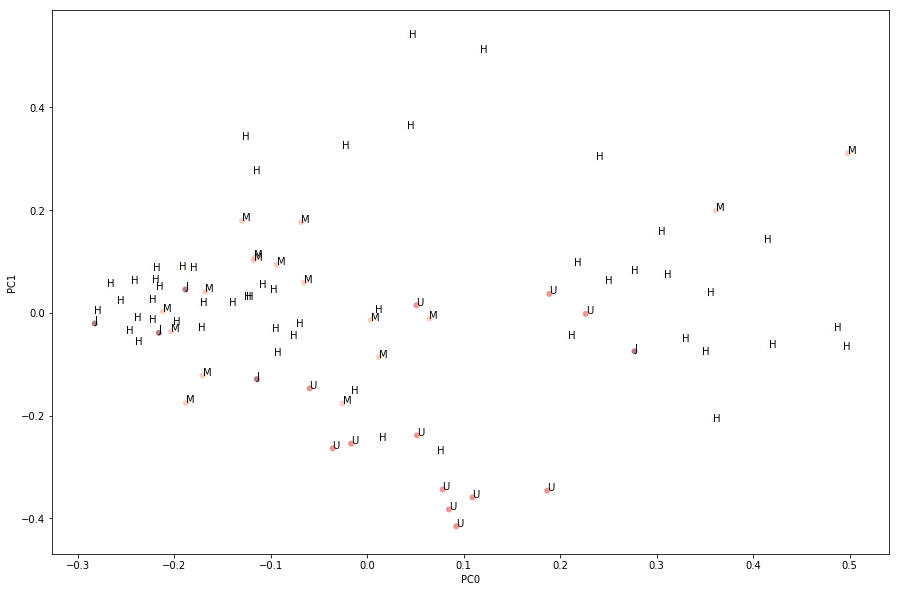

In [115]:
plot_pca(projected, 0, 1)

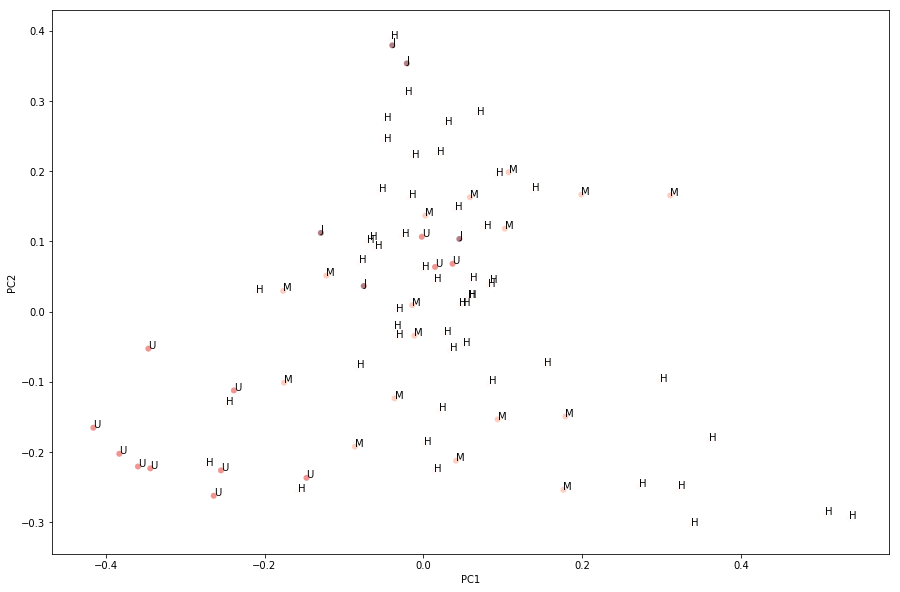

In [116]:
plot_pca(projected, 1, 2)

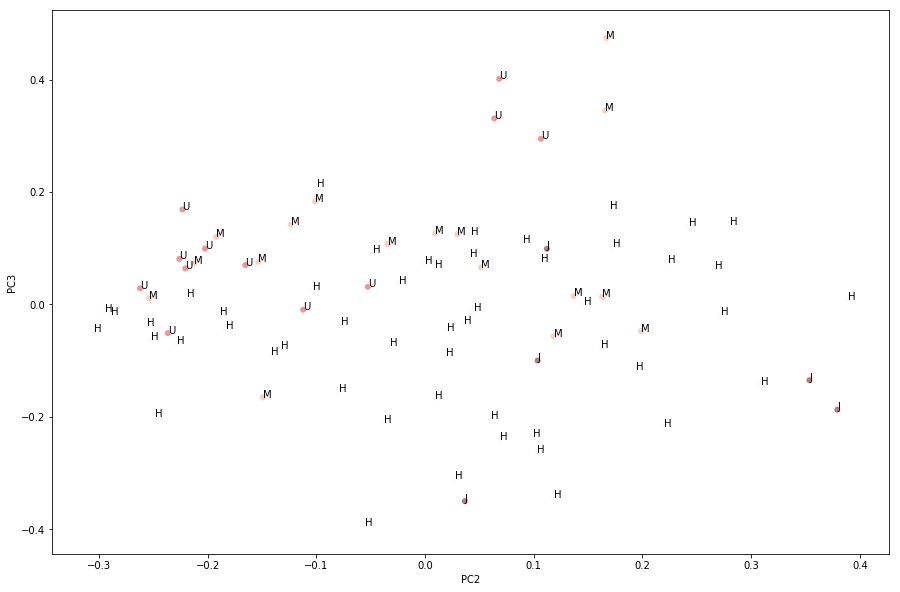

In [117]:
plot_pca(projected, 2, 3)

## PCA Loadings

In [118]:
vocab = pd.DataFrame([(v, countVectorizer.vocabulary_[v]) for v in countVectorizer.vocabulary_], 
                    columns=['term_str', 'term_id'])
vocab = vocab.set_index('term_id').sort_index()

In [119]:
vocab.head()

,term_str
term_id,
0,1788
1,able
2,absolute
3,absolutely
4,abuse


In [120]:
COMPS = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
COMPS.columns = ["PC{}".format(i) for i in COMPS.columns]
COMPS.index = vocab.term_str

In [121]:
COMPS.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
1788,0.005719,-0.001658,-0.001675,0.000556,-0.003561,0.000890,-0.000685,0.002822,0.000054,0.000652
able,-0.005931,-0.004157,0.005037,0.000420,-0.000869,-0.005797,-0.004546,-0.002055,0.001291,0.002726
absolute,0.001874,0.000485,0.003282,0.000659,-0.003691,-0.002790,0.000966,-0.002754,-0.000902,-0.001469
absolutely,0.000273,0.001256,-0.003659,0.000970,-0.004959,0.000127,0.005833,-0.000516,-0.001554,0.002016
abuse,0.003026,-0.001864,-0.001664,-0.000552,-0.001417,0.004488,-0.002533,-0.000342,-0.001500,-0.000319


In [122]:
COMPS['PC0'].sort_values(ascending=False)

term_str
executive          0.071743
senate             0.058456
president          0.053866
legislative        0.034841
body               0.027605
office             0.026436
department         0.024975
magistrate         0.022749
judiciary          0.021836
council            0.020264
nomination         0.020236
judges             0.019761
departments        0.019607
appointment        0.019463
impeachments       0.018470
court              0.018131
governor           0.018128
appointments       0.017831
house              0.016736
man                0.014595
legislature        0.014046
chief              0.013817
representatives    0.013709
offices            0.013505
duration           0.013476
treaties           0.012724
assembly           0.012065
choice             0.011751
thirds             0.011579
responsibility     0.011239
                     ...   
navigation        -0.011945
commercial        -0.012149
duties            -0.012240
natural           -0.012428
defense    

In [123]:
COMPS['PC1'].sort_values(ascending=False)

term_str
courts             0.053532
court              0.032334
jurisdiction       0.029017
judiciary          0.026475
jury               0.023966
supreme            0.023002
authority          0.020600
power              0.019480
powers             0.019479
law                0.019415
judicial           0.017859
executive          0.017822
cases              0.016504
department         0.016161
laws               0.015741
clause             0.015200
tribunals          0.014957
judges             0.014935
trial              0.014701
appellate          0.014591
causes             0.014096
legislative        0.013934
cognizance         0.013025
union              0.011945
inferior           0.011688
concurrent         0.011671
departments        0.011545
constitution       0.010008
shall              0.008704
confederation      0.008639
                     ...   
property          -0.009296
period            -0.009330
circumstances     -0.009407
senators          -0.009606
population 

In [124]:
COMPS['PC2'].sort_values(ascending=False)

term_str
executive          0.036013
nations            0.028033
war                0.027220
armies             0.025184
military           0.024155
confederacies      0.020190
peace              0.018906
militia            0.017843
council            0.016664
magistrate         0.016293
establishments     0.016163
army               0.015698
navigation         0.015532
europe             0.015201
defense            0.013922
standing           0.013493
britain            0.013403
strength           0.012857
man                0.012028
america            0.011724
foreign            0.011243
neighbors          0.011167
confederacy        0.010776
kept               0.010748
wars               0.010743
troops             0.010463
emperor            0.010290
trade              0.010244
chief              0.010242
good               0.009771
                     ...   
senate            -0.010758
representation    -0.011137
representative    -0.011242
authority         -0.011275
citizens   

## HCA

### Generate similarity matrix

In [125]:
SIMS = pdist(countMatrix, metric='cosine')

### Generate HCA tree

In [126]:
TREE = sch.linkage(SIMS, method='ward')

### Plot tree

In the digrams, the length of the two legs of the U-link represents the distance between the child clusters.  It is also the
cophenetic distance between original observations in the two children clusters.

In [127]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, 60))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", distance_sort=True)
    plt.tick_params(axis='both', which='major', labelsize=18)

In [128]:
labels = ["{}. {}: {}".format(code[1], code[0], title) for code, title in zip(codes, titles)]

<Figure size 432x288 with 0 Axes>

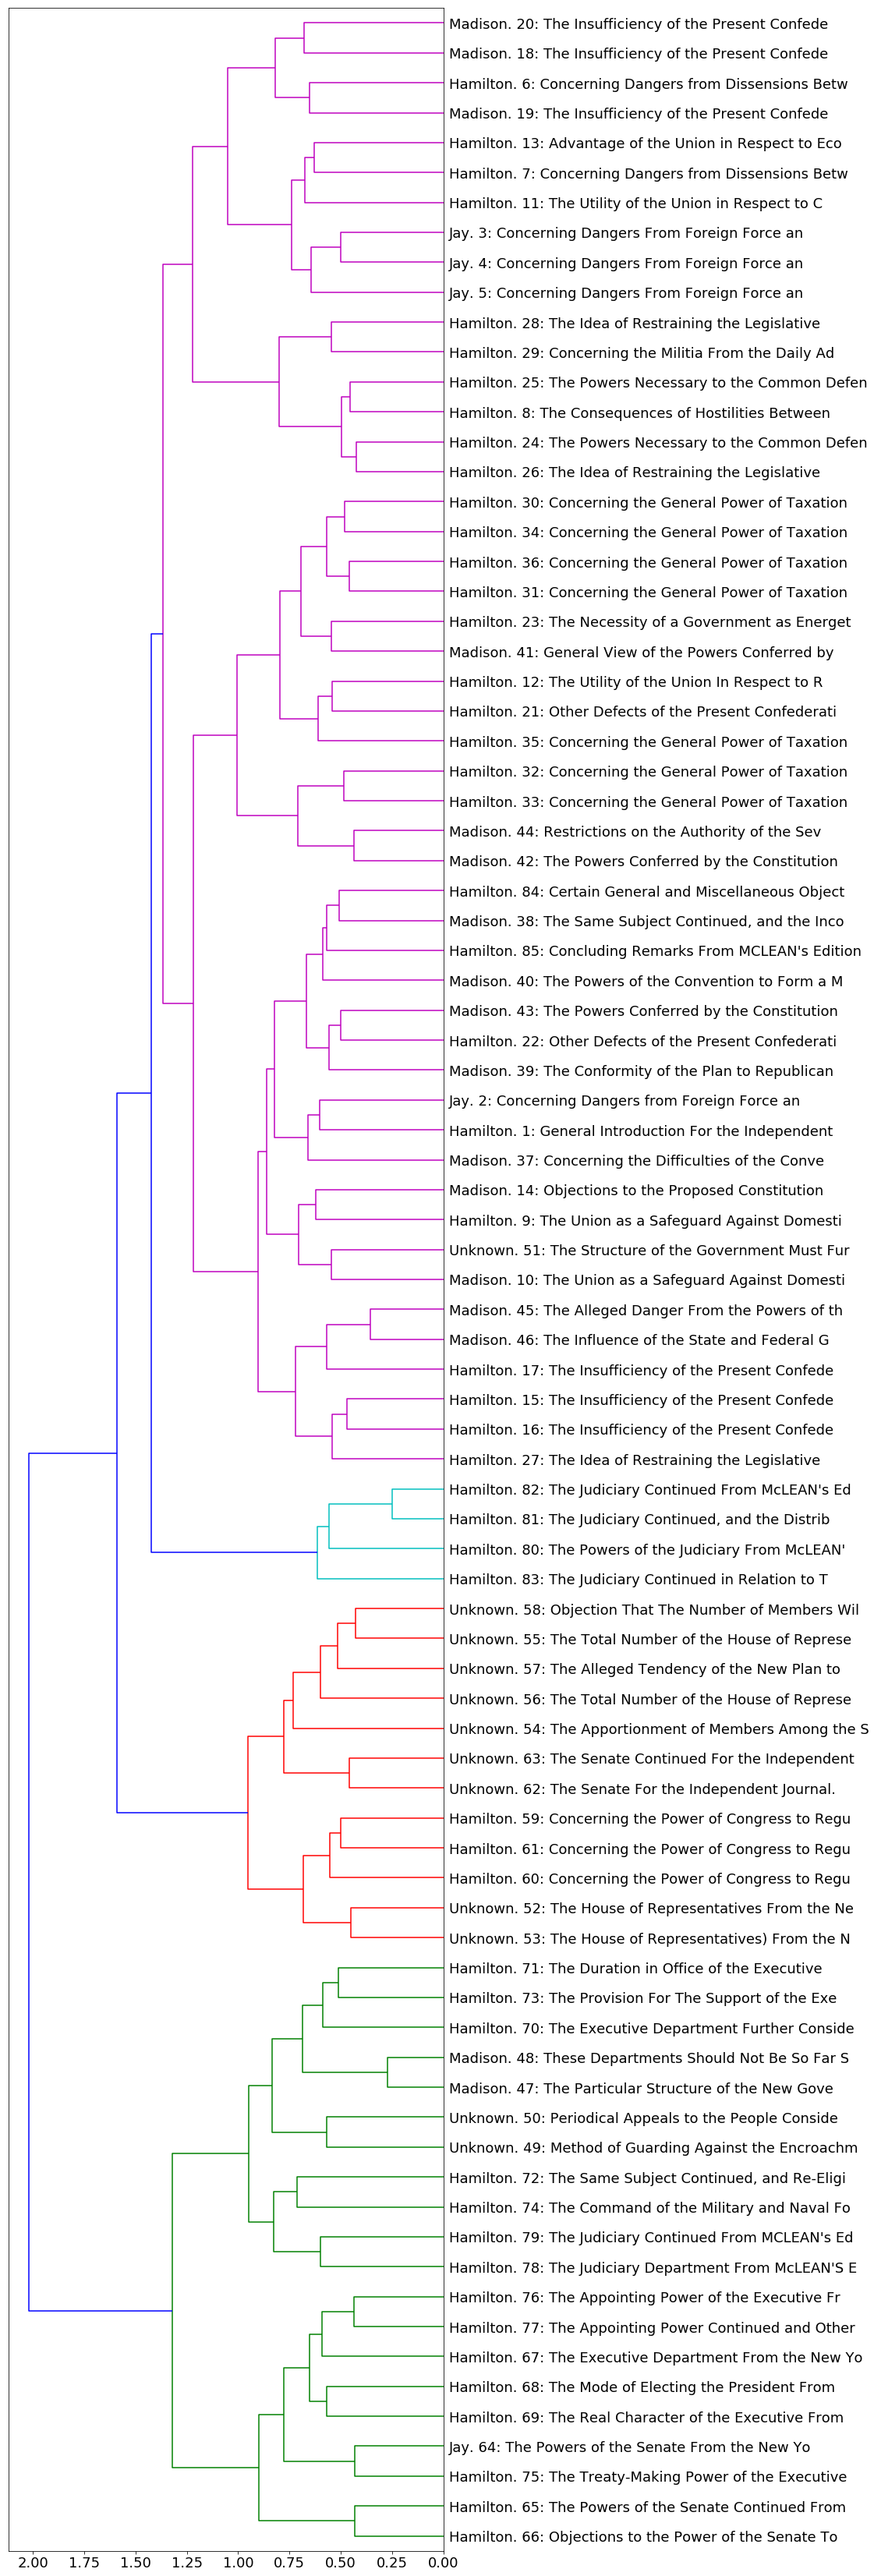

In [129]:
plot_tree(TREE, labels)

## The "Answers"

See [Wikipedia](https://en.wikipedia.org/wiki/The_Federalist_Papers#Authorship)

* Alexander Hamilton (51 articles: No. 1, 6–9, 11–13, 15–17, 21–36, 59–61, and 65–85)
* James Madison (29 articles: No. 10, 14, 18–20,[11] 37–58 and 62–63)
* John Jay (5 articles: No. 2–5 and 64).

In [139]:
# END
key = dict(
    H = "1, 6–9, 11–13, 15–17, 21–36, 59–61, 65–85",
    M = "10, 14, 18–20, 37–58, 62–63",
    J = "2-5, 64"
)

In [248]:
import re
author_map = []
for author in key:
    for item in key[author].split(', '):
        vals = re.split(r'[–-]', item)
        if len(vals) == 1:
            author_map.append((author, vals[0]))
        else:
            for i in range(int(vals[0]), int(vals[-1])+1):
                author_map.append((author, i))

In [258]:
authors = pd.DataFrame(author_map, columns=['author','chap_id'])
authors.chap_id = authors.chap_id.astype('int')
authors = authors.set_index('chap_id')
authors = authors.sort_index().values

In [259]:
answers = pd.DataFrame(author_map, columns=['actual_author', 'chap_id'])
answers.chap_id = answers.chap_id.astype('int')
answers = answers.set_index('chap_id')
answers = answers.sort_index()

In [251]:
df = pd.DataFrame(codes, columns=['chap_num','author'])
df['content'] = texts
df.content = df.content.str.replace(r'\n+', ' ').str.strip()
df.chap_num = df.chap_num.astype('int')
df = df.set_index('chap_num')
df = df.sort_index()

In [260]:
df['actual'] = answers

In [262]:
df.head()

,author,content,actual
chap_num,,,
1,Hamilton,General Introduction For the Independent Journ...,H
2,Jay,Concerning Dangers from Foreign Force and Infl...,J
3,Jay,The Same Subject Continued (Concerning Dangers...,J
4,Jay,The Same Subject Continued (Concerning Dangers...,J
5,Jay,The Same Subject Continued (Concerning Dangers...,J
